In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import re
!pip install -q wordcloud
!pip install torchmetrics
import wordcloud
from torch.utils.data import Dataset
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')
from torchtext.vocab import GloVe
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.core.display import Path
from gensim.scripts.glove2word2vec import glove2word2vec
import torch
import torch.nn as nn
from torchvision import datasets 
from torchvision.transforms import ToTensor
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader , RandomSampler
import random
import os
os.environ['PYTHONHASHSEED'] = str(69)
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import f1_score 
from torchmetrics import ConfusionMatrix
!pip install transformers
from transformers import BertTokenizer, BertModel, BertTokenizerFast

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

bertmodel = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(bertmodel)

def randreset(s):  #making sure each run will yield consistent results
	random.seed(s)
	np.random.seed(s)
	torch.manual_seed(s)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False
	torch.cuda.manual_seed_all(s)
	os.environ['PYTHONHASHSEED'] = str(s)
 
class CustomDataset(Dataset):
  def __init__(self, X, Y, tokenizer, maxlen):
    self.X = []
    self.Y = []
    self.tokenizer = tokenizer
    self.maxlen = maxlen

    for (x,y) in zip(X,Y):
      self.X.append(self.tokenizer.encode_plus(x, add_special_tokens=True, max_length=self.maxlen, padding='max_length', truncation=True, return_tensors='pt' , return_token_type_ids=False, return_attention_mask=True).to(device))
      self.Y.append(torch.tensor(y, dtype=torch.long, device=device))

  def __len__(self):
    return len(self.Y)

  def __getitem__(self, index):
    return (self.X[index]['input_ids'], self.X[index]['attention_mask'], self.Y[index])

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 13.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.0 MB/s eta 0:00:00
cuda


In [2]:
path = '/content/drive/My Drive/AI2/HW3/imdb-reviews.csv' 
modelpath = '/content/drive/My Drive/AI2/HW3/myNN.pt'
df = pd.read_csv(path,  sep='\t', lineterminator='\n')

df['review'] = df['review'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes so don't becomes dont
df['review'] = [r.lower() for r in df['review'] ]   #making everything lowercase
df['review'] = df['review'].apply(lambda r: re.sub(r'<br /><br />', ' ', r))  #removing this wierd sequence found in some reviews
df['review'] = df['review'].apply(lambda r: re.sub(r'[^a-z]', ' ', r))   #only keeping letters
rem = stopwords.words('english')
df['review'] = df['review'].apply(lambda r: ' '.join([word for word in r.split() if word not in rem]))
# max = df['review'].map(lambda r: len(r.split())).max()
# print(max)  #1436   is the maximum review in words
 
X = list(df['review'].values)
Y = list(df['rating'].apply(lambda r: 1 if r > 5 else 0))

testd = CustomDataset(X, Y, tokenizer, 182)
test_dataloader = DataLoader(testd , batch_size=40,sampler=RandomSampler(testd))

In [3]:
class BERTmodel(nn.Module):
  def __init__(self, dr, H, activation):
    super(BERTmodel, self).__init__()
    self.bertlayer = BertModel.from_pretrained(bertmodel).to(device)
    self.linear = nn.Sequential(
          nn.Linear(768, H, device=device),   #768 is the output of the bert model
          activation(),
		      nn.Dropout(dr),
          nn.Linear(H,2, device=device),
        )

  def forward(self, ids, mask):
    out = self.bertlayer(ids, mask)
    return self.linear(out[0][:, 0, :])

  def predict(self, dataloader):
    pred = torch.tensor([], device='cpu')
    true = torch.tensor([], dtype=torch.int, device='cpu')  #using tensors so I can control that they are in the cpu in order for sklearn's functions to not complain
    with torch.no_grad():
      self.eval()
      for (inputid, attentionmask, labels) in dataloader:
        _, y_pred = torch.max(self(inputid.squeeze(), attentionmask.squeeze()), 1)
        pred = torch.cat((pred, y_pred.cpu()))
        true = torch.cat((true, labels.squeeze().cpu()))
      return pred, true

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test f1 score is 0.9774262254850162
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     22500
           1       0.98      0.98      0.98     22508

    accuracy                           0.98     45008
   macro avg       0.98      0.98      0.98     45008
weighted avg       0.98      0.98      0.98     45008



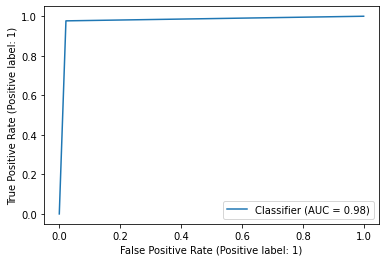

In [4]:
model = BERTmodel(0.1, 54, nn.CELU)
model.load_state_dict(torch.load(modelpath))

pred, true = model.predict(test_dataloader)
print(f"test f1 score is {f1_score(true, pred, average='weighted')}")
print(classification_report(true, pred))
RocCurveDisplay.from_predictions(true, pred)
plt.show()